# Model Testing


* Logistic Regression
* Decision Trees
* SVM

Most important scoring metric: 
* want to avoid false positives
* but also want to avoid false negatives
* f1 score

(*Remember in the presentation to explain what scores that aren't accuracy mean. Show Helen your slides on Monday*)

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

pd.set_option('display.max_columns', None)
plt.rcParams['figure.facecolor']='w'

import warnings
warnings.filterwarnings('ignore')

In [2]:
#set up train and test

test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
X_test = test.drop(columns = 'loan_status')
y_test = test.loan_status

X = train.drop(columns = 'loan_status')
y = train.loan_status

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [6]:
#first passthrough

stanscaler = StandardScaler()

X_train_scaled = stanscaler.fit_transform(X_train)
X_val_scaled = stanscaler.transform(X_val)
X_test_scaled = stanscaler.transform(X_test)

In [7]:
pca = PCA(n_components = 3)

X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [8]:
logmodel = LogisticRegression()

logmodel.fit(X_train_pca, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
logmodel.score(X_val_pca, y_val)

0.8715596330275229

Text(0.5, 1.0, 'Scree Plot')

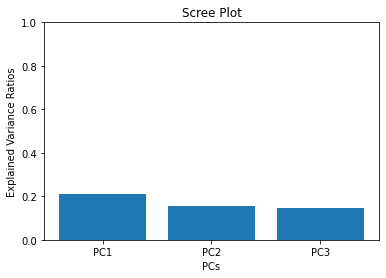

In [10]:
#setting PCA params

plt.bar(['PC'+str(num) for num in range(1, pca.n_components_+1)],
        pca.explained_variance_ratio_)

plt.xlabel('PCs')
plt.ylabel('Explained Variance Ratios')

plt.ylim(0,1)

plt.title('Scree Plot')

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
params = {
    'clf__C': list(range(1,10)),
    'clf__solver': ['liblinear', 'lbfgs', 'newton-dg','sag','saga'],
    'clf__penalty': ['l1','l2','elasticnet','none']
}

In [13]:
from sklearn.pipeline import Pipeline

In [14]:
log_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('clf', LogisticRegression())])

In [15]:

gridsearch_log = GridSearchCV(log_pipeline,
                             params,
                             scoring = 'f1',
                             cv = 5,
                             n_jobs = -1)

In [16]:
gridsearch_log.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
             

In [17]:
gridsearch_log.best_score_

0.9476749378532311

In [18]:
gridsearch_log.best_params_

{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

In [30]:
best_logmodel = LogisticRegression(C = 1, penalty = 'l2', solver = 'lbfgs')

In [31]:
best_logmodel.fit(X_train_scaled, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
best_logmodel.score(X_val_scaled, y_val)

0.8715596330275229

In [33]:
y_train_pred = best_logmodel.predict(X_train_scaled)
y_val_pred = best_logmodel.predict(X_val_scaled)
y_test_pred = best_logmodel.predict(X_test_scaled)

In [34]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score

In [39]:
recall_score(y_train, y_train_pred), recall_score(y_val, y_val_pred), recall_score(y_test, y_test_pred)

#why are these scores so good???

(0.9948717948717949, 0.9578947368421052, 1.0)

In [41]:
precision_score(y_train, y_train_pred), precision_score(y_val, y_val_pred), precision_score(y_test, y_test_pred)

(0.9150943396226415, 0.900990099009901, 0.9029850746268657)

In [42]:
f1_score(y_train, y_train_pred), f1_score(y_val, y_val_pred), f1_score(y_test, y_test_pred)

(0.9533169533169534, 0.9285714285714285, 0.9490196078431373)

Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression')

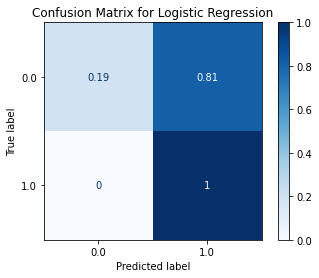

In [76]:
plot_confusion_matrix(best_logmodel, 
                      X_test_scaled,
                      y_test,
                      cmap= 'Blues', 
                      normalize = 'true')
plt.title('Confusion Matrix for Logistic Regression')

#high false positive

## Decision Trees

In [28]:
from sklearn.tree import DecisionTreeClassifier

In [55]:
params = {
    'clf__max_depth': [2,3,4,5,6],
    'clf__min_samples_split': [0.05,0.1,0.25,0.5,0.8],
    'clf__max_features': [1,2,3,4,5,6,7,8],
    'clf__criterion': ['gini','entropy'],
    'clf__splitter': ['best','random']}

In [56]:
tree_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('clf', DecisionTreeClassifier())])

In [61]:
gridsearch_tree = GridSearchCV(tree_pipeline,
                             params,
                             scoring = 'precision',
                             cv = 5,
                             n_jobs = -1)

In [62]:
gridsearch_tree.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                     

In [63]:
gridsearch_tree.best_score_

0.9273324347752168

In [64]:
gridsearch_tree.best_params_

{'clf__criterion': 'entropy',
 'clf__max_depth': 5,
 'clf__max_features': 3,
 'clf__min_samples_split': 0.1,
 'clf__splitter': 'best'}

In [65]:
best_treemodel = DecisionTreeClassifier(criterion = 'entropy', 
                                        max_depth=5, max_features = 3, min_samples_split = 0.1, 
                                        splitter = 'best')

In [67]:
best_treemodel.fit(X_train_scaled, y_train)
y_train_pred = best_treemodel.predict(X_train_scaled)
y_val_pred = best_treemodel.predict(X_val_scaled)
y_test_pred = best_treemodel.predict(X_test_scaled)

In [70]:
def getscores (true, pred):
    print(f'Recall: {recall_score(true,pred)} \n Precision: {precision_score(true,pred)} \n F1: {f1_score(true,pred)}')

In [73]:
getscores(y_train, y_train_pred)
getscores(y_val, y_val_pred)
getscores(y_test, y_test_pred)

Recall: 1.0 
 Precision: 0.9219858156028369 
 F1: 0.959409594095941
Recall: 1.0 
 Precision: 0.9047619047619048 
 F1: 0.9500000000000001
Recall: 0.9917355371900827 
 Precision: 0.916030534351145 
 F1: 0.9523809523809524


Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression')

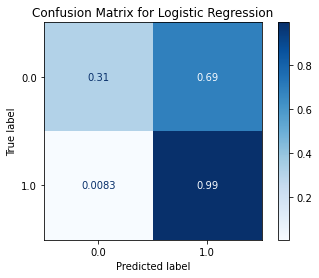

In [75]:
plot_confusion_matrix(best_treemodel, 
                      X_test_scaled,
                      y_test,
                      cmap= 'Blues', 
                      normalize = 'true')
plt.title('Confusion Matrix for Logistic Regression')

#aaaaaah why so many false positives?